# App Reviews Sentiment Analysis - ChatGPT

## Import Required Libraries

In [1]:
import os
import csv
import ast
import pickle
import joblib
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from io import StringIO
from wordcloud import WordCloud

from gensim.models import Word2Vec

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense

## Data Loading

In [2]:
df = pd.read_csv('preprocessed_reviews.csv')
df.head()

,content,score,text_stopword,result
0,Aplikasi yang sangat berguna untuk menunjang p...,5,"['aplikasi', 'berguna', 'menunjang', 'produkti...",aplikasi berguna menunjang produktifitas menca...
1,Mengapa Gpt-4 tidak ad lagi?? padahal model it...,1,"['gpt', 'model', 'detail', 'point', 'singkat',...",gpt model detail point singkat detail langsung...
2,"Di fitur terbaru, saat saya mengedit pesan, ja...",1,"['fitur', 'terbaru', 'mengedit', 'pesan', 'mel...",fitur terbaru mengedit pesan melenceng ai kada...
3,"Setelah update ke GPT-5, chat Al terasa lebih ...",3,"['update', 'gpt', 'chat', 'al', 'kaku', 'diban...",update gpt chat al kaku dibanding fitur bebas ...
4,"ChatGPT sudah sangat bagus menurut saya, infor...",4,"['chatgpt', 'bagus', 'informasi', 'jawabannya'...",chatgpt bagus informasi jawabannya kekurangann...


## Data Assesing

In [3]:
def assess_dataframe(df):

    print("Data Assessment Report")

    print(f"\nShape of dataset: {df.shape[0]} Rows x {df.shape[1]} Columns")

    print("\nColumn Information:")
    info_table = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Null Count": df.isnull().sum(),
        "Unique Values": df.nunique(),
    })
    print(info_table)
    

    dup_count = df.duplicated().sum()
    print(f"\nDuplicate Rows: {dup_count}")

    print("\nData Assessment Completed.")
    
assess_dataframe(df)

Data Assessment Report

Shape of dataset: 37643 Rows x 4 Columns

Column Information:
              DataType  Non-Null Count  Null Count  Unique Values
content         object           37643           0          37411
score            int64           37643           0              5
text_stopword   object           37643           0          32747
result          object           37537         106          32746

Duplicate Rows: 0

Data Assessment Completed.


In [4]:
df = df.dropna()
df.head(len(df))

,content,score,text_stopword,result
0,Aplikasi yang sangat berguna untuk menunjang p...,5,"['aplikasi', 'berguna', 'menunjang', 'produkti...",aplikasi berguna menunjang produktifitas menca...
1,Mengapa Gpt-4 tidak ad lagi?? padahal model it...,1,"['gpt', 'model', 'detail', 'point', 'singkat',...",gpt model detail point singkat detail langsung...
2,"Di fitur terbaru, saat saya mengedit pesan, ja...",1,"['fitur', 'terbaru', 'mengedit', 'pesan', 'mel...",fitur terbaru mengedit pesan melenceng ai kada...
3,"Setelah update ke GPT-5, chat Al terasa lebih ...",3,"['update', 'gpt', 'chat', 'al', 'kaku', 'diban...",update gpt chat al kaku dibanding fitur bebas ...
4,"ChatGPT sudah sangat bagus menurut saya, infor...",4,"['chatgpt', 'bagus', 'informasi', 'jawabannya'...",chatgpt bagus informasi jawabannya kekurangann...
...,...,...,...,...
37638,selangkah lebih maju dari pada google,4,"['selangkah', 'maju', 'google']",selangkah maju google
37639,apk bagus karena bisa membuat gambar menjadi hd,5,"['apk', 'bagus', 'gambar', 'hd']",apk bagus gambar hd
37640,keren bisa jadi teman curhat,5,"['keren', 'teman', 'curhat']",keren teman curhat
37641,membantu mengerjakan tugas 😍😍😍😍,5,"['membantu', 'tugas']",membantu tugas


## Labeling

In [5]:
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [6]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = 'positive'

    elif score < 0:
        polarity = 'negative'

    else:
        polarity = 'neutral'

    return score, polarity

results = df['text_stopword'].apply(eval).apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df['polarity_score'] = results[0]
df['polarity'] = results[1]

print(df['polarity'].value_counts())

polarity
positive    28709
negative     5502
neutral      3326
Name: count, dtype: int64


In [7]:
df.head()

,content,score,text_stopword,result,polarity_score,polarity
0,Aplikasi yang sangat berguna untuk menunjang p...,5,"['aplikasi', 'berguna', 'menunjang', 'produkti...",aplikasi berguna menunjang produktifitas menca...,7,positive
1,Mengapa Gpt-4 tidak ad lagi?? padahal model it...,1,"['gpt', 'model', 'detail', 'point', 'singkat',...",gpt model detail point singkat detail langsung...,17,positive
2,"Di fitur terbaru, saat saya mengedit pesan, ja...",1,"['fitur', 'terbaru', 'mengedit', 'pesan', 'mel...",fitur terbaru mengedit pesan melenceng ai kada...,34,positive
3,"Setelah update ke GPT-5, chat Al terasa lebih ...",3,"['update', 'gpt', 'chat', 'al', 'kaku', 'diban...",update gpt chat al kaku dibanding fitur bebas ...,14,positive
4,"ChatGPT sudah sangat bagus menurut saya, infor...",4,"['chatgpt', 'bagus', 'informasi', 'jawabannya'...",chatgpt bagus informasi jawabannya kekurangann...,19,positive


## Exp(lora/lana)tory Data Analysis (EDA)

### Sentiment Proportions

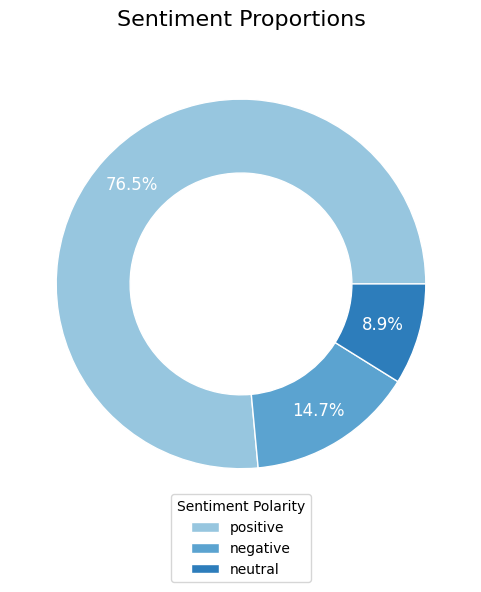

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in df['polarity'].value_counts()]
labels = list(df['polarity'].value_counts().index)
colors = plt.cm.Blues(range(100, 100 + 40 * len(labels), 40))

wedges, texts, autotexts = ax.pie(
    x=sizes,
    autopct='%1.1f%%',
    textprops={'fontsize': 12, 'color': 'white'},
    pctdistance=0.8,
    colors=colors,
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)

legends = ax.legend(wedges, labels, title="Sentiment Polarity", loc="center", bbox_to_anchor=(0, 0, 1, -0.1))
ax.set_title('Sentiment Proportions', fontsize=16, pad=20)
plt.show()

### Word Cloud

In [9]:
df['text_stopword'] = df['text_stopword'].apply(ast.literal_eval)

#### Positive Word Cloud

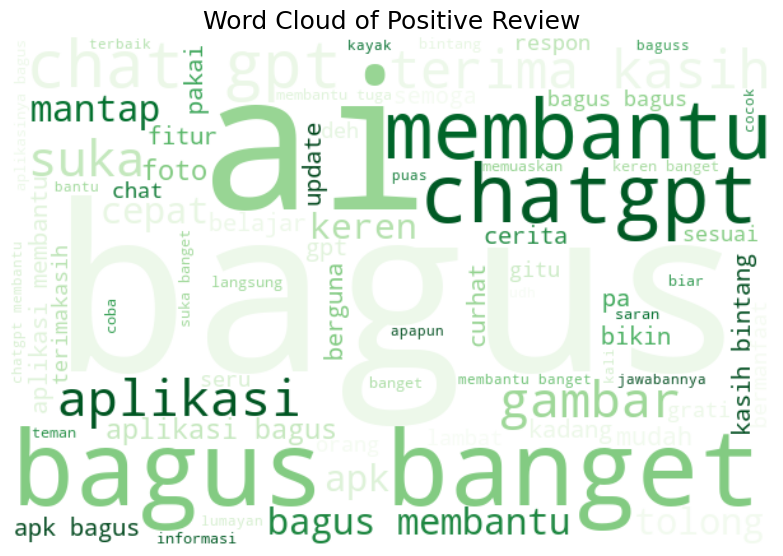

In [10]:
positive_words = df[df['polarity'] == 'positive']
positive_words = positive_words[['result', 'polarity_score', 'polarity','text_stopword']]
positive_words = positive_words.sort_values(by='polarity_score', ascending=False)
positive_words = positive_words.reset_index(drop=True)
positive_words.index += 1

list_words = ''
for tweet in positive_words['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

wordcloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    min_font_size=10,
    colormap='Greens'
).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Positive Review', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()


#### Negative Word Cloud

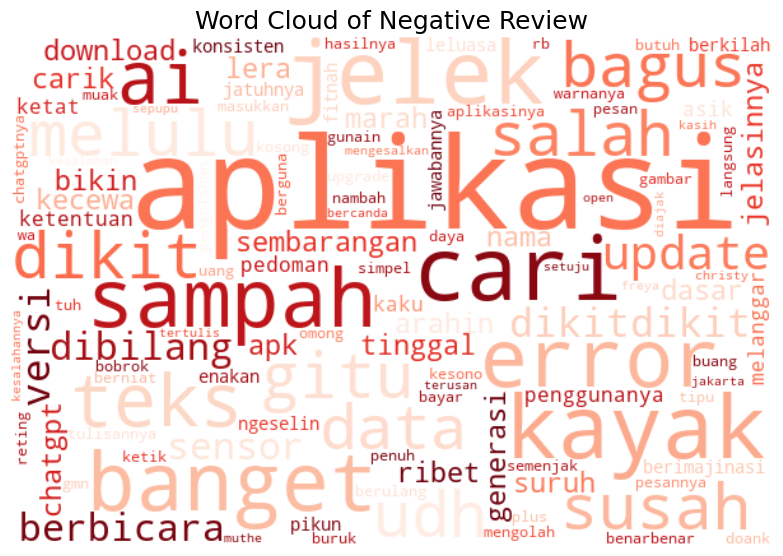

In [11]:
negative_words = df[df['polarity'] == 'negative']
negative_words = negative_words[['result', 'polarity_score', 'polarity','text_stopword']]
negative_words = negative_words.sort_values(by='polarity_score', ascending=True)
negative_words = negative_words[0:10]
negative_words = negative_words.reset_index(drop=True)
negative_words.index += 1

list_words = ''
for tweet in negative_words['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

wordcloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    min_font_size=10,
    colormap='Reds'
).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Review', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

#### Neutral Word Cloud

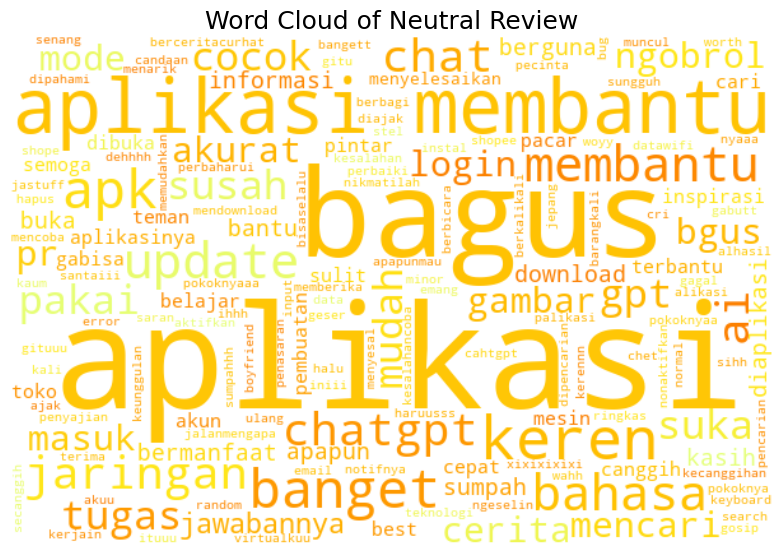

In [12]:
neutral_words = df[df['polarity'] == 'neutral']
neutral_words = neutral_words[['result', 'polarity_score', 'polarity','text_stopword']]
neutral_words = neutral_words.sort_values(by='polarity_score', ascending=True)
neutral_words = neutral_words[:100]
neutral_words = neutral_words.reset_index(drop=True)
neutral_words.index += 1

list_words = ''
for tweet in neutral_words['text_stopword']:
    for word in tweet:
        list_words += ' ' + word

wordcloud = WordCloud(
    width=600,
    height=400,
    background_color='white',
    min_font_size=10,
    colormap='Wistia'
).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Review', fontsize=18)
ax.grid(False)
ax.imshow(wordcloud, interpolation='bilinear')
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## Data Preparation

### Feature Extraction

#### TF-IDF

In [13]:
tfidf_X = df['result']
tfidf_y = df['polarity']

tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.9)
X_tfidf = tfidf.fit_transform(tfidf_X)

features_df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df_tfidf.head()

,admin,aga,ah,ai,ainya,ajak,akal,akhirakhir,akses,aktif,...,whatsapp,wifi,wkwk,wkwkwk,worth,wow,yaaa,yah,yng,youtube
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.101193,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Word2Vec

In [14]:
w2v_X = df['text_stopword']
w2v_y = df['polarity']

w2v_model = Word2Vec(sentences=w2v_X, vector_size=200, window=7, min_count=1, workers=4, epochs=50)

def get_average_word2vec(tokens, model, k=200):
    vec = np.zeros(k)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

X_vectors = np.array([get_average_word2vec(tokens, w2v_model, k=200) for tokens in w2v_X])

features_df_w2v = pd.DataFrame(X_vectors)
features_df_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.046808,0.550224,0.127758,-0.514438,0.106998,-0.154376,-0.514844,0.518071,0.139984,0.269805,...,-0.534403,-0.013360,0.615062,0.374753,0.114548,0.585357,-0.372524,0.085620,0.057052,-0.209524
1,0.258615,0.627123,-0.106823,-1.049301,-0.101316,0.048526,0.283779,-0.746079,0.070755,-0.701306,...,-0.319185,-0.068963,0.325137,0.564561,-0.451201,-0.109736,-0.181807,1.003808,-0.384620,1.289455
2,0.269413,0.661025,0.096251,-0.550696,-0.236564,-0.261846,0.839217,-0.147399,-0.450276,0.281548,...,-0.474440,0.146302,0.321915,0.723721,-0.217830,0.713456,-0.087248,1.030404,-0.142463,0.894185
3,0.792246,0.824678,0.078030,-0.647437,-0.017278,0.153088,0.736807,-0.140895,-0.687916,-0.003450,...,-0.371895,-0.015520,-0.024835,0.425368,0.463917,0.200621,-0.227499,0.315633,0.830438,0.323199
4,-0.280369,0.314524,-0.074255,0.113162,-0.191729,-0.032703,0.138345,-0.461599,-0.516289,0.057901,...,-0.817528,-0.046028,-0.064927,0.857518,0.181294,-0.546647,-0.301955,0.189407,0.706161,0.521869


### Preprocessing - Deep Learning

In [15]:
X_token = df['result']
y = df['polarity']

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_token)
X_seq = tokenizer.texts_to_sequences(X_token)
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')

le = LabelEncoder()
y_encoded = le.fit_transform(y)

### Data Splitting

#### TF-IDF - 80:20

In [16]:
X_train_tfidf_8020, X_test_tfidf_8020, y_train_tfidf_8020, y_test_tfidf_8020 = train_test_split(X_tfidf, tfidf_y, test_size=0.2, random_state=42)

#### W2V - 80:20

In [17]:
X_train_w2v_8020, X_test_w2v_8020, y_train_w2v_8020, y_test_w2v_8020 = train_test_split(X_vectors, w2v_y, test_size=0.2, random_state=42)

#### 80:20 -  Deep Learning

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_encoded, test_size=0.2, random_state=42)

## Modelling (3 Different Schemes)

### Support Vector Machine - TF-IDF - 80:20

In [19]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf_8020, y_train_tfidf_8020)

y_pred_train_svm = svm_model.predict(X_train_tfidf_8020)
y_pred_test_svm = svm_model.predict(X_test_tfidf_8020)

accuracy_train_svm = accuracy_score(y_train_tfidf_8020, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test_tfidf_8020, y_pred_test_svm)

print('SVM - Train Accuracy:', accuracy_train_svm)
print('SVM - Test Accuracy:', accuracy_test_svm)

cm = confusion_matrix(y_test_tfidf_8020, y_pred_test_svm)

print("\nConfusion Matrix (Test Set):")
print(cm)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_tfidf_8020, y_pred_test_svm))

SVM - Train Accuracy: 0.9444869959039595
SVM - Test Accuracy: 0.9350026638252531

Confusion Matrix (Test Set):
[[ 944   44  127]
 [  64  475  115]
 [  60   78 5601]]

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.88      0.85      0.86      1115
     neutral       0.80      0.73      0.76       654
    positive       0.96      0.98      0.97      5739

    accuracy                           0.94      7508
   macro avg       0.88      0.85      0.86      7508
weighted avg       0.93      0.94      0.93      7508



### Random Forest - Word2Vec - 80:20

In [20]:
random_forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

random_forest.fit(X_train_w2v_8020, y_train_w2v_8020)

y_pred_train_rf_w2v = random_forest.predict(X_train_w2v_8020)
y_pred_test_rf_w2v = random_forest.predict(X_test_w2v_8020)

accuracy_train_rf_w2v = accuracy_score(y_pred_train_rf_w2v, y_train_w2v_8020)
accuracy_test_rf_w2v = accuracy_score(y_pred_test_rf_w2v, y_test_w2v_8020)

print('Random Forest - Train Accuracy:', accuracy_train_rf_w2v)
print('Random Forest - Test Accuracy:', accuracy_test_rf_w2v)

cm = confusion_matrix(y_test_w2v_8020, y_pred_test_rf_w2v)

print("\nConfusion Matrix (Test Set):")
print(cm)

print("\nClassification Report (Test Set):")
print(classification_report(y_test_w2v_8020, y_pred_test_rf_w2v))

Random Forest - Train Accuracy: 0.9820506843384728
Random Forest - Test Accuracy: 0.846430474160895

Confusion Matrix (Test Set):
[[ 401    9  705]
 [  23  245  386]
 [  21    9 5709]]

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.90      0.36      0.51      1115
     neutral       0.93      0.37      0.53       654
    positive       0.84      0.99      0.91      5739

    accuracy                           0.85      7508
   macro avg       0.89      0.58      0.65      7508
weighted avg       0.86      0.85      0.82      7508



### Convolutional Neural Network - 80:20

In [21]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10


c:\Users\Rahfi\miniconda3\envs\env310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


751/751 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8637 - loss: 0.3897 - val_accuracy: 0.9194 - val_loss: 0.2471
Epoch 2/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9336 - loss: 0.1963 - val_accuracy: 0.9254 - val_loss: 0.2329
Epoch 3/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9531 - loss: 0.1376 - val_accuracy: 0.9226 - val_loss: 0.2559
Epoch 4/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9626 - loss: 0.1061 - val_accuracy: 0.9221 - val_loss: 0.3117
Epoch 5/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9711 - loss: 0.0876 - val_accuracy: 0.9184 - val_loss: 0.3237
Epoch 6/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9752 - loss: 0.0729 - val_accuracy: 0.9081 - val_loss: 0.3600
Epoch 7/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9799 - loss: 0.0605 - val_accuracy: 0.9148 - val_loss: 0.4487
Epoch 8/10
751/751 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9848 - loss: 0.0474 - val_accuracy: 0.91

In [22]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print("CNN - Train Accuracy:", train_acc)
print("CNN - Test Accuracy:", test_acc)

CNN - Train Accuracy: 0.9785873889923096
CNN - Test Accuracy: 0.9120937585830688


## Save Models

In [23]:
os.makedirs('artifacts/cnn', exist_ok=True)

joblib.dump(svm_model, 'artifacts/svm_model.pkl')
joblib.dump(random_forest, 'artifacts/random_forest.pkl')
joblib.dump(tfidf, 'artifacts/tfidf_vectorizer.pkl')
joblib.dump(w2v_model, 'artifacts/word2vec_model.pkl')

with open("artifacts/cnn/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("artifacts/cnn/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

final_path = "artifacts/cnn/cnn_model.keras"
model.save(final_path)